<a href="https://colab.research.google.com/github/dcmoura/spyql/blob/master/notebooks/json_benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The fastest tools for querying large JSON datasets

Benchmark with several command-line tools with focus on large files that fit into the disk of a standard machine but might not fit into memory. 

## Dataset
A subset of the [Amazon book reviews dataset](http://deepyeti.ucsd.edu/jianmo/amazon/) with 10 GB. 

## Benchmarking challenges

*   **Map**: a new column is calculated for all rows (both input and output are large)
*   **Aggregation**/Reduce: the average of all rows of a column is calculated (only the input is large)
*   **Subset**/Filter: the first 100 values of a column matching a search criteria are returned (only a part of the input needs to be processed)

## Test criteria

*   **Processing Time test**: tools fail this test when taking 2x or more time than the fastest tool to process 1GB of data, unless the difference is in the order of the tenths of a second. 
*   **Memory Scalability test**: none of the operations in the challenges require having the full dataset loaded into memory. Any tool whose memory consumption is proportional to the size of the input or output fails this test. 


# Results' Summary

Tool | Stars</br>(GitHub) | Processing Time</br>(Map/Aggr/Filter) | Memory Scalability</br>(Map/Aggr/Filter) | Conclusion 
:---|:---:|:---:|:---:|:---
[SPyQL](https://github.com/dcmoura/spyql) | [![GitHub stars](https://img.shields.io/github/stars/dcmoura/spyql?label=)](https://github.com/dcmoura/spyql) | 👍 👍 👍 | 👍 👍 👍 | The fastest for large files (>=100MB). 2nd lowest memory footprint (22MB), independently of input size. It is able to stop execution as soon as it reaches the required number of records (e.g. LIMIT).
[jq](https://github.com/stedolan/jq) | [![GitHub stars](https://img.shields.io/github/stars/stedolan/jq?label=)](https://github.com/stedolan/jq) | 👍 👍 👍 | 👍 👍 👍 | Fast but not the fastest. The lowest memory footprint (6MB) if you can avoid building arrays in memory. It is able to stop execution as soon as it reaches the required number of records (e.g. LIMIT).
[trdsql](https://github.com/noborus/trdsql) | [![GitHub stars](https://img.shields.io/github/stars/noborus/trdsql?label=)](https://github.com/noborus/trdsql) | ❌ ❌ ❌ | 👍 👍 👍 | Among the slowest but always with a low memory footprint (29MB). Always processes the full dataset.
[Miller](https://github.com/johnkerl/miller) | [![GitHub stars](https://img.shields.io/github/stars/johnkerl/miller?label=)](https://github.com/johnkerl/miller) | 👍 👍 ❌ | ❌ ❌ ❌ | The fastest for small files (<=10MB). Memory grows  with size of input data => always reads the full dataset into memory.
[OctoSQL](https://github.com/cube2222/octosql) | [![GitHub stars](https://img.shields.io/github/stars/cube2222/octosql?label=)](https://github.com/cube2222/octosql) | ❌ 👍 ❌ | ❌ 👍 ❌ | Fast with a small footprint when aggregating data. Otherwise, among the slowest and with a large footprint => reads the full dataset into memory.
[spark-sql CLI](https://github.com/apache/spark) | [![GitHub stars](https://img.shields.io/github/stars/apache/spark?label=)](https://github.com/apache/spark) | ❌ ❌ ❌ | ❌ 👍 👍 | Large overhead, catching-up on GB-sized data. Always processes the full dataset. Output size does not scale (full output is written to the driver's memory in the CLI's implementation).
[Pandas](https://github.com/pandas-dev/pandas) | [![GitHub stars](https://img.shields.io/github/stars/pandas-dev/pandas?label=)](https://github.com/pandas-dev/pandas) | ❌ ❌ ❌ | ❌ ❌ ❌ | Among the slowest and with a large footprint => always reads the full dataset into memory (batching was not used as it results in long programs). 
[DSQ](https://github.com/multiprocessio/dsq) | [![GitHub stars](https://img.shields.io/github/stars/multiprocessio/dsq?label=)](https://github.com/multiprocessio/dsq) | ❌ ❌ ❌ | ❌ ❌ ❌ | Among the slowest and with a large footprint => always reads the full dataset into memory.

# Feedback

Leave your comments in this [GitHub issue](https://github.com/dcmoura/spyql/issues/72). Thanks! 

-----

*Disclaimer: this benchmark is part of the [SPyQL project](https://github.com/dcmoura/spyql)*

# Setup

In [ ]:
# SETUP
!pip install -q ipython-autotime
%load_ext autotime

!apt -qq update
!apt -qq install -y time
!apt -qq install -y jq

!pip install -q --upgrade "pip>=20.3"
!pip install -q --upgrade orjson
!pip install -q spyql

!add-apt-repository -y ppa:longsleep/golang-backports > /dev/null 2>&1
!apt -qq install -y golang-go 

!go install github.com/multiprocessio/dsq@latest > /dev/null 2>&1
!go install github.com/cube2222/octosql@latest > /dev/null 2>&1
!cp /root/go/bin/* /usr/local/bin

!go install github.com/noborus/trdsql@latest
!cd /root/go/pkg/mod/github.com/noborus/trdsql@v0.9.1/ ; make ; make install
!cp /root/go/pkg/mod/github.com/noborus/trdsql@v0.9.1/trdsql /usr/local/bin

!apt-get install miller

!wget https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz
!tar -xzf spark-3.2.1-bin-hadoop2.7.tgz
!mv spark-3.2.1-bin-hadoop2.7 spark

40 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following NEW packages will be installed:
  time
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 26.2 kB of archives.
After this operation, 79.9 kB of additional disk space will be used.
Selecting previously unselected package time.
(Reading database ... 155455 files and directories currently installed.)
Preparing to unpack .../time_1.7-25.1build1_amd64.deb ...
Unpacking time (1.7-25.1build1) ...
Setting up time (1.7-25.1build1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
The following additional packages will be installed:
  libjq1 libonig4
The following NEW packages will be installed:
  jq libjq1 libonig4
0 upgraded, 3 newly installed, 0 to remove and 40 not upgraded.
Need to get 276 kB of archives.
After this operation, 930 kB of additional disk space will be used.
Selecting previously unselected package libonig4:amd64.
(Reading database ... 155466 files and directorie

In [ ]:
# VERSIONS
!lsb_release -a

!python --version
!go version
!java --version

!jq --version
!spyql --version
!dsq --version
!octosql --version
!mlr --version
!trdsql --version
!spark/bin/spark-sql --version

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.5 LTS
Release:	18.04
Codename:	bionic
Python 3.7.13
go version go1.18 linux/amd64
openjdk 11.0.14.1 2022-02-08
OpenJDK Runtime Environment (build 11.0.14.1+1-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.14.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
jq-1.5-1-a5b5cbe
spyql, version 0.6.0
dsq latest
octosql version dev
Miller 5.3.0
trdsql version devel
Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 3.2.1
      /_/
                        
Using Scala version 2.12.15, OpenJDK 64-Bit Server VM, 11.0.14.1
Branch HEAD
Compiled by user hgao on 2022-01-20T20:15:47Z
Revision 4f25b3f71238a00508a356591553f2dfa89f8290
Url https://github.com/apache/spark
Type --help for more information.
time: 4.64 s (started: 2022-04-11 20:51:26 +00:00)


In [ ]:
#download dataset
!curl -s -N http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Books_5.json.gz | gunzip --stdout | head -11675000 > books.json
!ls -lh books.json

-rw-r--r-- 1 root root 9.4G Apr 11 20:53 books.json
time: 2min 1s (started: 2022-04-11 20:51:31 +00:00)


# Benchmark

In [ ]:
#Create empty log files and a benchmarking script

#Execution time, memory peak, exit code, and command executed:
!> performance.log
#Size of the sample file:
!> sample_size.log
#Challenge being addressed:
!> challenge.log

#Benchmarking script
!echo 'echo "Running: $@"' > bench.sh
!echo '/usr/bin/time -o performance.log -a -f"%e\t%M\t%x\t%C" "$@" > /dev/null 2>&1' >> bench.sh
!echo 'mv sample_size.log sample_size.old; cat sample_size.old sample_size.this >> sample_size.log' >> bench.sh
!echo 'mv challenge.log challenge.old; cat challenge.old challenge.this >> challenge.log' >> bench.sh
!echo 'tail -1 performance.log' >> bench.sh
!chmod +x bench.sh

time: 1.06 s (started: 2022-04-11 20:53:33 +00:00)


In [ ]:
OCTOSQL_NO_TELEMETRY=1 
for i in range(3,11):
  n_bytes = 10**i
  print(f"---- RUN {i} ----")
  !echo "Bytes: $n_bytes"
  #!head -n "$n" books.json > sample.json
  n_lines = !head -c "$n_bytes" books.json | wc -l
  n_lines = int(n_lines[0]) + 1 
  !echo "Lines: $n_lines"
  !head -n "$n_lines" books.json > sample.json
  !wc sample.json > sample_size.this
  !cat sample_size.this

  !echo "Aggregation" > challenge.this #average of the overall score for the full sample (REDUCE)
  !cat challenge.this
  if i <= 9:
    # utils that do not scale (memory)
    !./bench.sh mlr --ijson stats1 -a mean -f overall sample.json
    !./bench.sh dsq -s jsonl "SELECT AVG(overall) FROM {}" < sample.json
    !./bench.sh python3 -c "import pandas as pd; print(pd.read_json('sample.json', lines=True, convert_dates=False)['overall'].mean())"

  !./bench.sh octosql "SELECT AVG(overall) FROM sample.json"
  !./bench.sh jq -n '[inputs.overall] | add/length' sample.json
  !./bench.sh jq -n 'def sigma(s): reduce s as $x([0,0]; [.[0]+$x, .[1]+1]); sigma(inputs | .overall) | .[0] / .[1]' sample.json
  !./bench.sh spyql "SELECT avg_agg(json->overall) FROM orjson" < sample.json
  !./bench.sh trdsql "SELECT avg(overall) FROM sample.json"
  !./bench.sh spark/bin/spark-sql --driver-memory 4g --executor-memory 2g -e "SELECT avg(overall) FROM json.\`sample.json\`" 

  !echo "Map" > challenge.this # name, date and normalized score (MAP)
  !cat challenge.this
  if i <= 9:
    # utils that do not scale (memory)
    !./bench.sh mlr --ijson put '$score = $overall/5.0' then cut -f reviewerName,reviewTime,score then rename reviewerName,name,reviewTime,date sample.json
    !./bench.sh dsq -s jsonl "SELECT reviewerName as name, reviewTime as date, overall/5.0 as score FROM {}" < sample.json
    !./bench.sh python3 -c "import pandas as pd, sys; df = pd.read_json('sample.json', lines=True, convert_dates=False); df['score']=df['overall']/5.0; df = df[['reviewerName','reviewTime','score']]; df.rename(columns = {'reviewerName':'name', 'reviewTime':'date'}, inplace = True); df.to_csv(sys.stdout,index=False,chunksize=1000)"
    !./bench.sh octosql "SELECT reviewerName as name, reviewTime as date, overall as score FROM sample.json"
  !./bench.sh jq -c '.score = .overall/5.0 | {name: .reviewerName, date: .reviewerTime, score: .score}' sample.json
  !./bench.sh spyql "SELECT json->reviewerName as name, json->reviewTime as date, json->overall/5.0 as score FROM orjson" < sample.json
  !./bench.sh trdsql "SELECT reviewerName as name, reviewTime as date, overall/5.0 as score FROM sample.json"
  !./bench.sh spark/bin/spark-sql --driver-memory 8g --executor-memory 1g -e "SELECT reviewerName as name, reviewTime as date, overall/5.0 as score FROM json.\`sample.json\`"  

  !echo "Subset" > challenge.this # any 100 reviewTexts with overall score of 4 (FILTER)
  !cat challenge.this
  if i<=9:
    !./bench.sh mlr --ijson filter '$overall == 4' then cut -f reviewText then head -n 100 sample.json
    !./bench.sh dsq -s jsonl "SELECT reviewText FROM {} WHERE overall = 4.0 LIMIT 100" < sample.json
    !./bench.sh python3 -c "import pandas as pd; df = pd.read_json('sample.json', lines=True, convert_dates=False); print(df.loc[df['overall']==4,'reviewText'][0:100])"
    !./bench.sh octosql "SELECT reviewText FROM sample.json WHERE overall=4.0 LIMIT 100"
  !./bench.sh bash -c "jq 'select(.overall==4) | .reviewText' sample.json | jq -n 'limit(100;inputs)'"
  !./bench.sh spyql "SELECT json->reviewText FROM orjson WHERE json->overall==4 LIMIT 100" < sample.json
  !./bench.sh trdsql "SELECT reviewText FROM sample.json WHERE overall=4.0 LIMIT 100"
  !./bench.sh spark/bin/spark-sql --driver-memory 4g --executor-memory 2g -e "SELECT reviewText FROM json.\`sample.json\` WHERE overall=4 LIMIT 100"     

---- RUN 3 ----
Bytes: 1000
Lines: 1
   1  191 1174 sample.json
Aggregation
Running: mlr --ijson stats1 -a mean -f overall sample.json
0.01	5556	0	mlr --ijson stats1 -a mean -f overall sample.json
Running: dsq -s jsonl SELECT AVG(overall) FROM {}
0.35	39384	0	dsq -s jsonl SELECT AVG(overall) FROM {}
Running: python3 -c import pandas as pd; print(pd.read_json('sample.json', lines=True, convert_dates=False)['overall'].mean())
1.86	85244	0	python3 -c import pandas as pd; print(pd.read_json('sample.json', lines=True, convert_dates=False)['overall'].mean())
Running: octosql SELECT AVG(overall) FROM sample.json
0.11	17600	0	octosql SELECT AVG(overall) FROM sample.json
Running: jq -n [inputs.overall] | add/length sample.json
0.02	5672	0	jq -n [inputs.overall] | add/length sample.json
Running: jq -n def sigma(s): reduce s as $x([0,0]; [.[0]+$x, .[1]+1]); sigma(inputs | .overall) | .[0] / .[1] sample.json
0.00	5768	0	jq -n def sigma(s): reduce s as $x([0,0]; [.[0]+$x, .[1]+1]); sigma(inputs | .

In [ ]:
!sed 's/\s\+/\t/g' sample_size.log | sed 's/^\t*//g' > size.log
!paste size.log challenge.log performance.log > all.log

time: 250 ms (started: 2022-04-11 22:02:28 +00:00)


In [ ]:
from google.colab import files, data_table
files.download('all.log')
files.download('performance.log')
data_table.enable_dataframe_formatter()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

time: 21.7 ms (started: 2022-04-11 22:02:28 +00:00)


# Analysis

In [ ]:
import pandas as pd
from math import *

df = pd.read_csv('all.log', delimiter = '\t', names = [
  'n_recs', 'n_words', 'bytes', 'fname', 'challenge', 'proc_time', 'memory', 'exit_code', 'cmd'
])
df['Memory Peak (MB)'] = df['memory']//1000
df['Processing Time (s)'] = df['proc_time']
df['Command'] = df['cmd']
df['Processing Rate (MB/s)'] = round(df['bytes'] * 1e-6 / df['proc_time'],1)
df['om'] = [round(log10(x)) for x in df['bytes'] ]
df['Tool'] = df['cmd'].str.replace('python3 -c import ', '').str.replace('spark/bin/', '').str.replace('bash -c ', '').str.split().str[0]
df["Variant"] = ''
df.loc[(df['Tool']=='jq') & (df['cmd'].str.find('reduce') > 0), "Variant"] = 'jq (reduce)'
df['Input Size (MB)'] = df['bytes']*1e-6

def result_table(challenge, cols = ['Tool', 'Command', 'Processing Time (s)', 'Processing Rate (MB/s)', 'Memory Peak (MB)']):
  print(f"{challenge} challenge: results for 1GB of input data") 
  sub_df = df[(df['challenge']==challenge) & (df['om']==9)][cols].sort_values(by = ['Processing Time (s)']) #.reset_index(drop=True)
  sub_df['Rank'] = range(1, len(sub_df)+1)
  return sub_df.set_index('Rank')

def result_plot(challenge, cols = ["Processing Time (s)", "Memory Peak (MB)"]):
  import matplotlib.pyplot as plt
  import matplotlib.ticker as mticker
  import seaborn as sns
  import numpy as np

  data = df[(df["Input Size (MB)"] >= 1) & (df['challenge']==challenge)]
  extra_opts = {} if len(data["Variant"].value_counts()) == 1 else {"style": "Variant"}
  fig, axs = plt.subplots(1,len(cols), figsize=(16,6))
  fig.set_dpi(100)
  fig.suptitle(f"{challenge} challenge")
  plt.subplots_adjust(wspace=0.3)
  for i,col in enumerate(cols):
    ax = axs[i]
    sns.lineplot(x="Input Size (MB)", y=col,
                hue="Tool",               
                marker = "o",
                data=data,
                ax = ax,
                **extra_opts)
    ax.legend(loc= 'best')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: format(x, ',.2f').rstrip('0').rstrip('.')))
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: format(x, ',.2f').rstrip('0').rstrip('.')))
    ax.grid(which='minor', linestyle=':', linewidth=0.5)
    ax.grid(which='major', linestyle='-', linewidth=0.5)
    ax.set_title(f"{col} vs Input Size (MB)")
  plt.show()

time: 1.32 s (started: 2022-04-11 22:02:28 +00:00)


# Map challenge

Name, date and normalized score for all reviews, while renaming properties' names

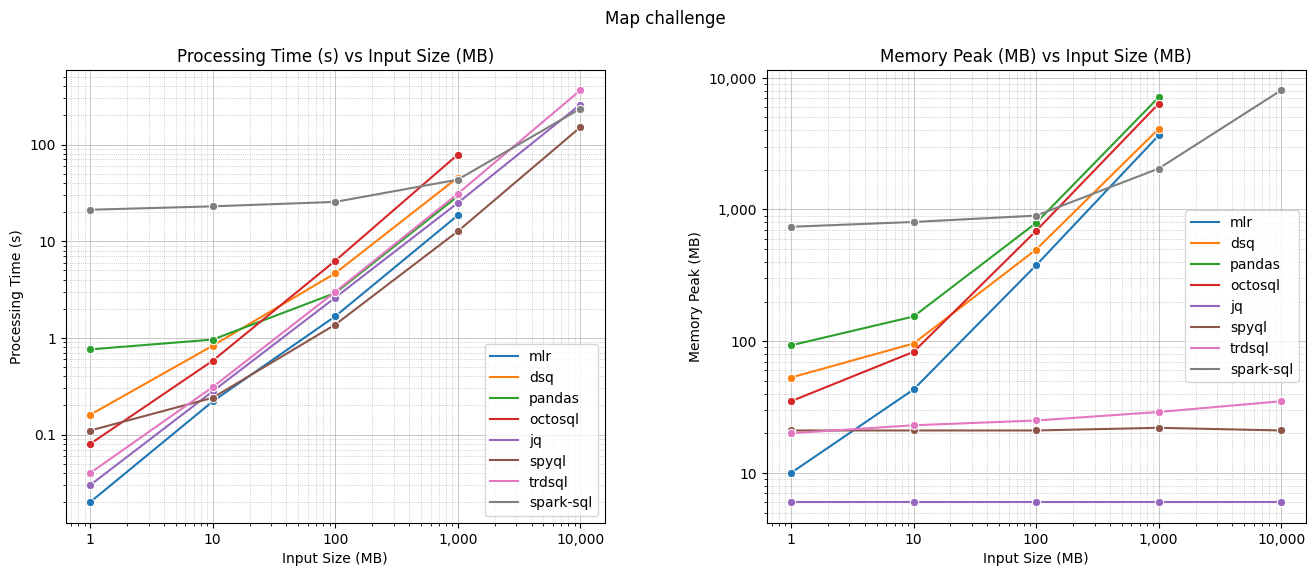

In [ ]:
result_plot("Map")

In [ ]:
result_table('Map')

time: 2.69 s (started: 2022-04-11 22:02:29 +00:00)
Map challenge: results for 1GB of input data


,Tool,Command,Processing Time (s),Processing Rate (MB/s),Memory Peak (MB)
Rank,,,,,
1,spyql,"spyql SELECT json->reviewerName as name, json-...",12.65,79.1,22
2,mlr,mlr --ijson put $score = $overall/5.0 then cut...,18.48,54.1,3647
3,jq,jq -c .score = .overall/5.0 | {name: .reviewer...,24.84,40.3,6
4,pandas,"python3 -c import pandas as pd, sys; df = pd.r...",29.15,34.3,7102
5,trdsql,"trdsql SELECT reviewerName as name, reviewTime...",30.96,32.3,29
6,spark-sql,spark/bin/spark-sql --driver-memory 8g --execu...,43.29,23.1,2044
7,dsq,"dsq -s jsonl SELECT reviewerName as name, revi...",45.52,22.0,4090
8,octosql,"octosql SELECT reviewerName as name, reviewTim...",78.59,12.7,6349


time: 60.8 ms (started: 2022-04-11 22:02:32 +00:00)


# Aggregation (reduce) challenge

Average overall score from all reviews

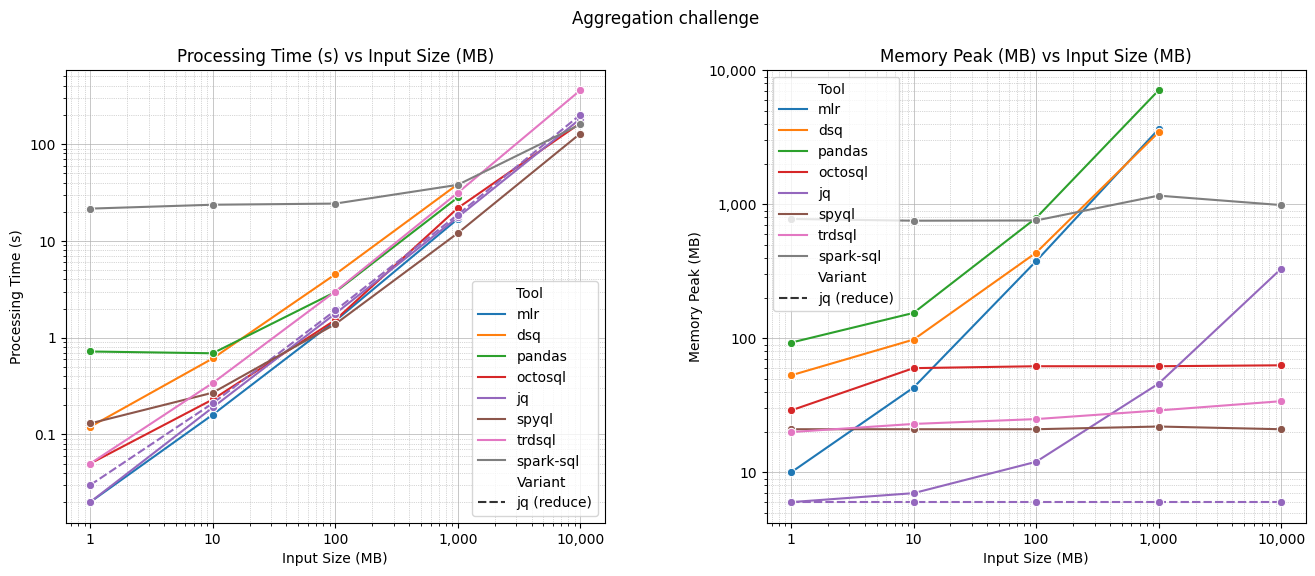

time: 1.88 s (started: 2022-04-11 22:02:32 +00:00)


In [ ]:
result_plot("Aggregation")

In [ ]:
result_table('Aggregation')

Aggregation challenge: results for 1GB of input data


,Tool,Command,Processing Time (s),Processing Rate (MB/s),Memory Peak (MB)
Rank,,,,,
1,spyql,spyql SELECT avg_agg(json->overall) FROM orjson,12.02,83.2,22
2,mlr,mlr --ijson stats1 -a mean -f overall sample.json,16.86,59.3,3646
3,jq,jq -n [inputs.overall] | add/length sample.json,17.56,56.9,46
4,jq,"jq -n def sigma(s): reduce s as $x([0,0]; [.[0...",18.64,53.6,6
5,octosql,octosql SELECT AVG(overall) FROM sample.json,21.82,45.8,62
6,pandas,python3 -c import pandas as pd; print(pd.read_...,28.09,35.6,7106
7,trdsql,trdsql SELECT avg(overall) FROM sample.json,31.40,31.8,29
8,spark-sql,spark/bin/spark-sql --driver-memory 4g --execu...,37.94,26.4,1163
9,dsq,dsq -s jsonl SELECT AVG(overall) FROM {},38.51,26.0,3455


time: 53.3 ms (started: 2022-04-11 22:02:34 +00:00)


# Subset (filter) challenge

Texts of any 100 reviews with overall score of 4

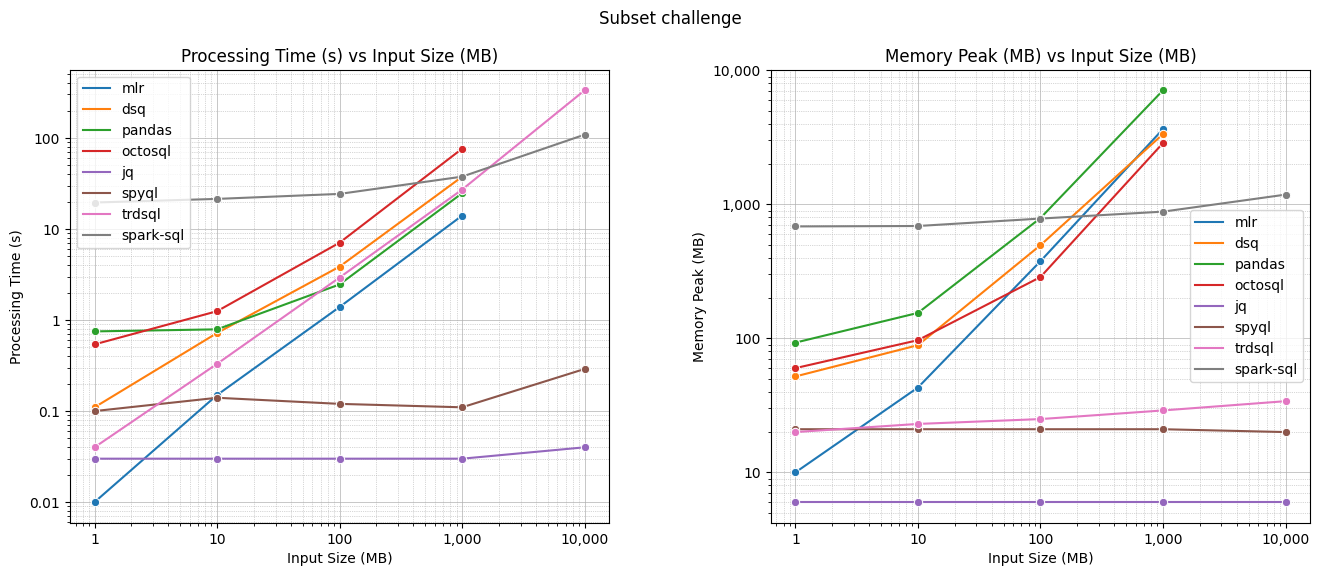

time: 1.9 s (started: 2022-04-11 22:02:34 +00:00)


In [ ]:
result_plot("Subset")

In [ ]:
result_table('Subset', ['Tool', 'Command', 'Processing Time (s)', 'Memory Peak (MB)'])

Subset challenge: results for 1GB of input data


,Tool,Command,Processing Time (s),Memory Peak (MB)
Rank,,,,
1,jq,bash -c jq 'select(.overall==4) | .reviewText'...,0.03,6
2,spyql,spyql SELECT json->reviewText FROM orjson WHER...,0.11,21
3,mlr,mlr --ijson filter $overall == 4 then cut -f r...,14.02,3647
4,pandas,python3 -c import pandas as pd; df = pd.read_j...,24.70,7103
5,trdsql,trdsql SELECT reviewText FROM sample.json WHER...,27.09,29
6,dsq,dsq -s jsonl SELECT reviewText FROM {} WHERE o...,37.48,3348
7,spark-sql,spark/bin/spark-sql --driver-memory 4g --execu...,37.56,883
8,octosql,octosql SELECT reviewText FROM sample.json WHE...,76.15,2868


time: 29.7 ms (started: 2022-04-11 22:02:36 +00:00)
